**https://goldinlocks.github.io/PAIRS-TRADING-WITH-A-KALMAN-FILTER/**

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from scipy import stats
import datetime as dt
import pandas as pd
import math
import os.path
import time
import json
import requests
import pandas_market_calendars as mcal
from datetime import timedelta, datetime
from dateutil import parser
import seaborn as sns
import matplotlib as mpl
import quantstats as qs
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import warnings
import ffn
import pyfolio as pf
from pandas_datareader import data as web
import yfinance as yfin

h:\anaconda\envs\backtest\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
yfin.pdr_override()

In [3]:
symbols = ['GDX','GDXJ','GLD', 'AAPL','GOOGL', 'META','TWTR','AMD',
           'NVDA','CSCO', 'ORCL', 'ATVI', 'TTWO', 'EA', 'HYG',
           'LQD', 'JNK', 'SLV', 'USLV', 'SIVR', 'USO', 'UWT',
           'QQQ', 'SPY', 'VOO', 'VDE', 'VTI', 'EMLP', 'VDC',
           'FSTA', 'KXI', 'IBB', 'VHT','VNQ', 'IYR', 'MSFT',
           'PG', 'TMF', 'UPRO', 'WFC', 'JPM', 'GS', 'CVX',
           'XOM', 'INTC', 'COST', 'WMT', 'T', 'VZ', 'CMCSA', 'AMZN']

In [4]:
def get_symbols(symbols,ohlc,begin_date=None,end_date=None):
    out = []
    new_symbols = []
    for symbol in symbols:
      df = web.get_data_yahoo(symbol,begin_date, end_date)
      df = df[ohlc]
      new_symbols.append(symbol)
      out.append(df.astype('float'))
    data = pd.concat(out, axis = 1)
    data.columns = new_symbols
    data = data.dropna(axis=1)
    return data.dropna(axis=1)

In [5]:
start = pd.Timestamp('2012-01-01')
#end = pd.Timestamp('2020-03-05')
end = dt.date.today()
prices = get_symbols(symbols,ohlc='Close',begin_date=start,end_date=end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

In [6]:
combo = prices.copy()
combo.index = pd.DatetimeIndex(combo.index)
combo.head()

,GDX,GDXJ,GLD,AAPL,GOOGL,AMD,NVDA,CSCO,ORCL,TTWO,EA,HYG,LQD,JNK,SLV,USLV,SIVR,USO,QQQ,SPY,VOO,VDE,VTI,VDC,KXI,IBB,VHT,VNQ,IYR,MSFT,PG,TMF,UPRO,WFC,JPM,GS,CVX,XOM,INTC,COST,WMT,T,VZ,CMCSA,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-03,53.799999,104.320000,155.919998,14.686786,16.651901,5.48,3.5100,18.629999,25.860001,14.00,21.299999,89.720001,113.669998,115.980003,28.830000,3333.000000,29.420000,317.519989,56.900002,127.500000,116.599998,103.540001,65.209999,81.489998,33.625000,35.106667,61.930000,58.490002,57.160000,26.770000,66.830002,17.092501,2.627500,28.430000,34.980000,95.360001,110.370003,86.000000,24.540001,84.599998,60.330002,22.945620,39.730000,12.250,8.9515
2012-01-04,53.740002,104.320000,156.710007,14.765714,16.723724,5.46,3.5500,18.990000,26.010000,14.00,20.290001,89.570000,113.760002,115.919998,28.389999,3180.000000,28.990000,318.160004,57.139999,127.699997,116.800003,103.849998,65.239998,81.269997,33.384998,34.956669,61.590000,57.490002,56.520000,27.400000,66.800003,16.514999,2.631667,28.559999,34.950001,94.739998,110.180000,86.019997,25.110001,84.070000,59.709999,22.983383,39.209999,12.365,8.8755
2012-01-05,53.900002,103.639999,157.779999,14.929643,16.491741,5.46,3.6775,18.920000,26.590000,14.66,20.530001,89.180000,113.269997,115.500000,28.510000,3221.000000,29.080000,313.359985,57.610001,128.039993,117.180000,103.410004,65.529999,81.150002,33.200001,35.450001,61.849998,58.029999,56.930000,27.680000,66.519997,16.405001,2.658333,29.020000,35.680000,94.580002,109.099998,85.760002,25.400000,83.260002,59.419998,22.960726,38.939999,12.475,8.8805
2012-01-06,53.349998,102.480003,157.199997,15.085714,16.266768,5.43,3.6350,18.850000,26.930000,14.76,19.670000,88.900002,113.709999,115.410004,27.910000,3023.800049,28.510000,313.760010,57.810001,127.709999,116.940002,102.779999,65.379997,80.660004,32.915001,35.736668,61.990002,57.840000,56.830002,28.110001,66.360001,16.770000,2.638750,28.940001,35.360001,93.419998,108.309998,85.120003,25.250000,81.129997,59.000000,22.416918,38.330002,12.345,9.1305
2012-01-09,53.650002,103.800003,156.500000,15.061786,15.577077,5.59,3.6350,18.969999,27.030001,14.91,19.420000,89.019997,113.540001,115.410004,28.129999,3098.800049,28.709999,312.640015,57.619999,128.020004,117.120003,103.169998,65.529999,80.769997,33.005001,36.233334,62.130001,57.639999,56.669998,27.740000,66.639999,16.687500,2.651667,29.299999,35.299999,94.690002,109.489998,85.500000,25.469999,79.010002,59.180000,22.401814,38.369999,12.605,8.9280


In [7]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2994 entries, 2012-01-03 to 2023-11-24
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDX     2994 non-null   float64
 1   GDXJ    2994 non-null   float64
 2   GLD     2994 non-null   float64
 3   AAPL    2994 non-null   float64
 4   GOOGL   2994 non-null   float64
 5   AMD     2994 non-null   float64
 6   NVDA    2994 non-null   float64
 7   CSCO    2994 non-null   float64
 8   ORCL    2994 non-null   float64
 9   TTWO    2994 non-null   float64
 10  EA      2994 non-null   float64
 11  HYG     2994 non-null   float64
 12  LQD     2994 non-null   float64
 13  JNK     2994 non-null   float64
 14  SLV     2994 non-null   float64
 15  USLV    2994 non-null   float64
 16  SIVR    2994 non-null   float64
 17  USO     2994 non-null   float64
 18  QQQ     2994 non-null   float64
 19  SPY     2994 non-null   float64
 20  VOO     2994 non-null   float64
 21  VDE     2994 non-nu

In [8]:
num_stocks = len(combo.columns)
print('Number of Stocks =', num_stocks)

Number of Stocks = 45


**Plot price series**

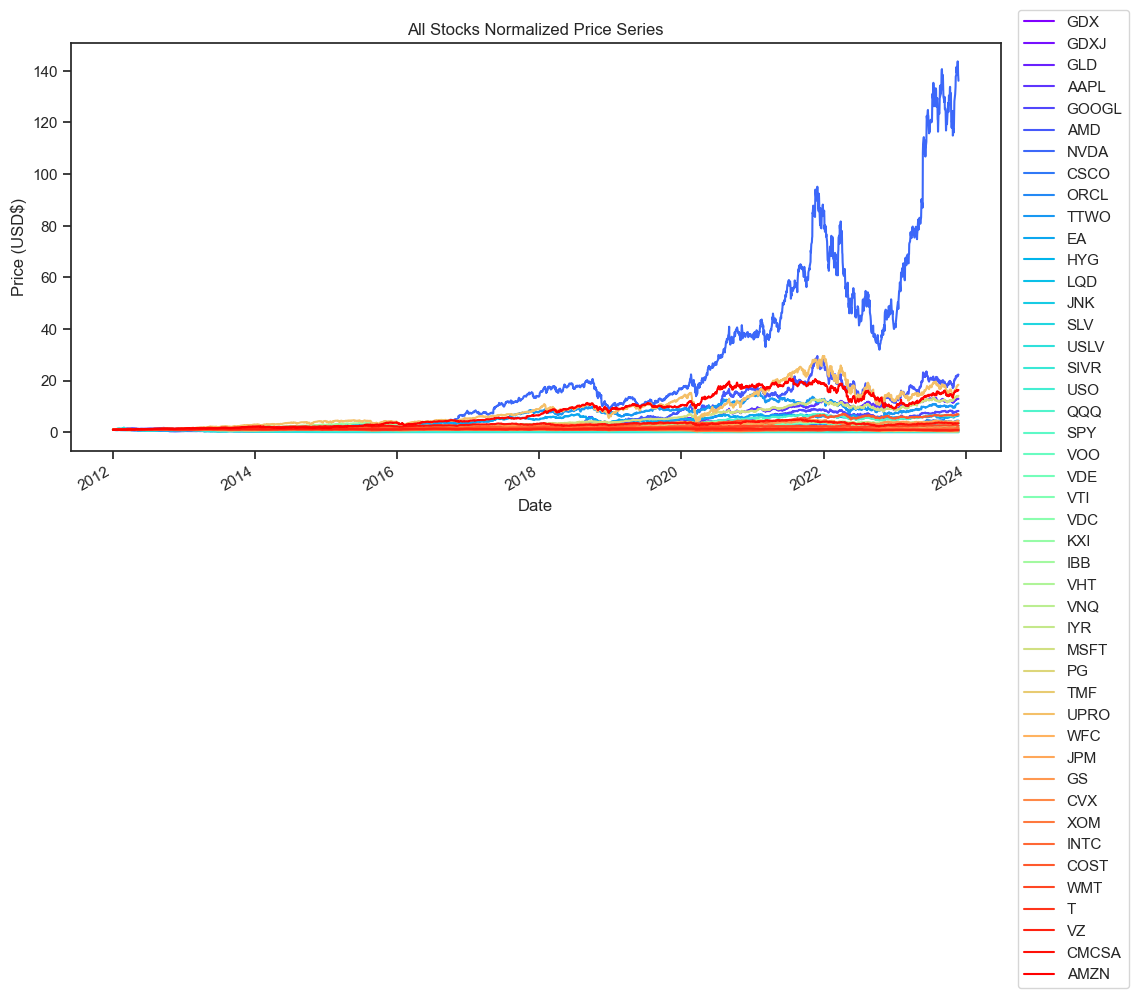

In [9]:
n_secs = len(combo.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
combo.div(combo.iloc[0,:]).plot(color=colors, figsize=(12, 6))# Normalize Prices
plt.title('All Stocks Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price (USD$)')
#plt.grid(b=None, which=u'major', axis=u'both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show()

In [10]:
# NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

In [11]:
df = combo

binance_symbols = df.columns

# Set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * 0.3)

# Run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix, pairs = find_cointegrated_pairs(df[:split])

# Convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

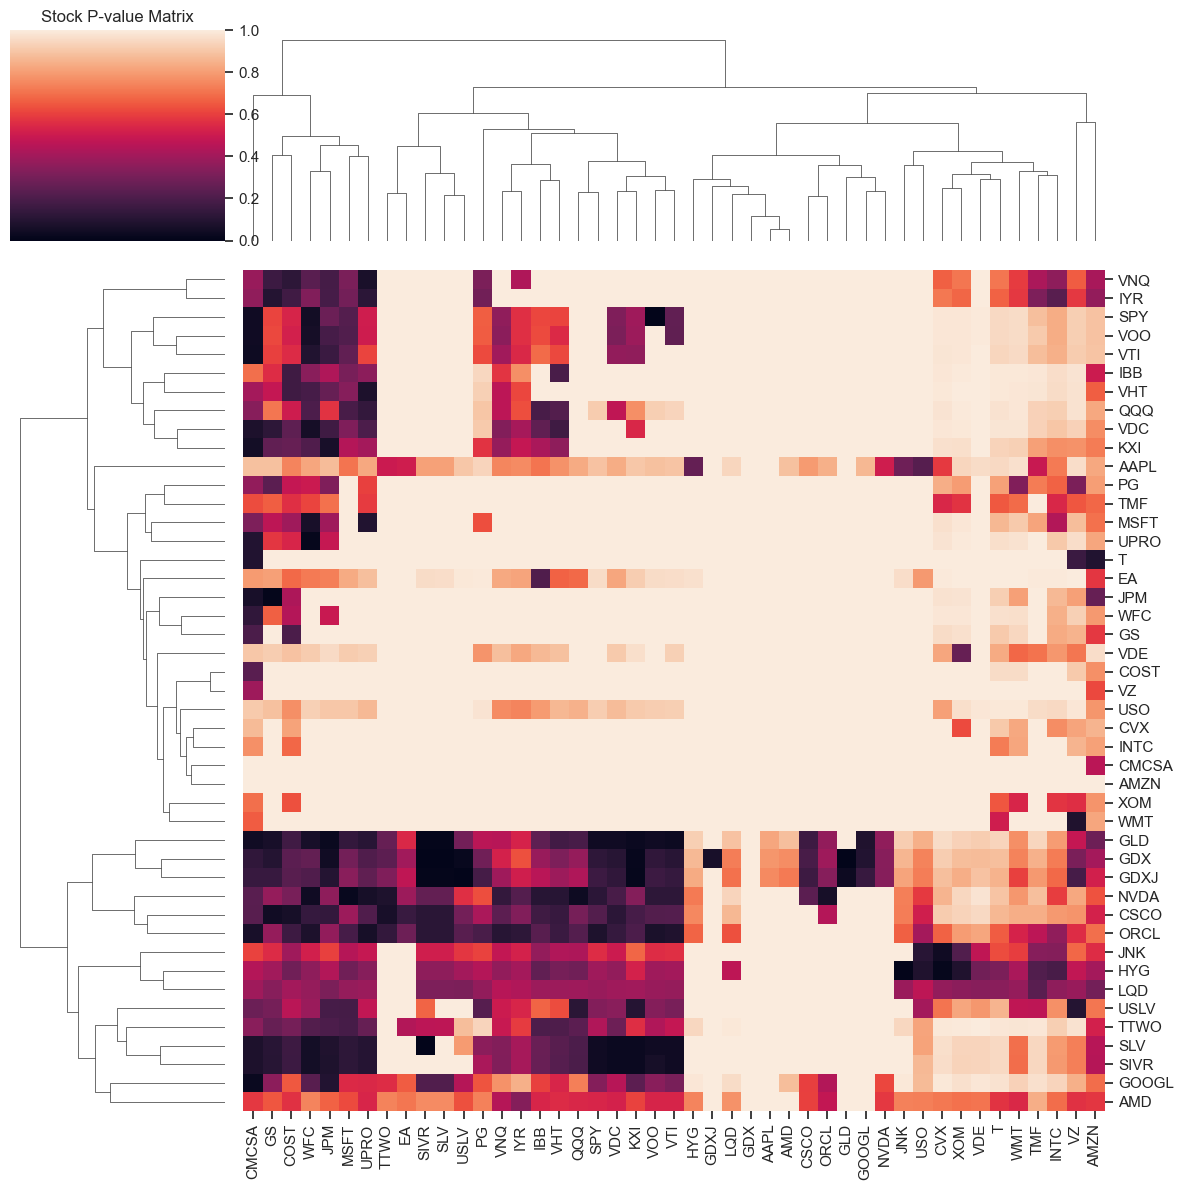

In [12]:
# Use Seaborn to plot a heatmap of our results matrix
sns.clustermap(pvalue_matrix_df, xticklabels=binance_symbols,yticklabels=binance_symbols, figsize=(12, 12))
plt.title('Stock P-value Matrix')
plt.tight_layout()
plt.show()

In [13]:
for pair in pairs:
    print("Asset {} and Asset {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Asset GDX and Asset GLD has a co-integration score of 0.0015
Asset GDX and Asset SLV has a co-integration score of 0.0038
Asset GDX and Asset USLV has a co-integration score of 0.0198
Asset GDX and Asset SIVR has a co-integration score of 0.0036
Asset GDX and Asset KXI has a co-integration score of 0.0174
Asset GDX and Asset JPM has a co-integration score of 0.0444
Asset GDXJ and Asset GLD has a co-integration score of 0.0324
Asset GDXJ and Asset SLV has a co-integration score of 0.011
Asset GDXJ and Asset USLV has a co-integration score of 0.0015
Asset GDXJ and Asset SIVR has a co-integration score of 0.0107
Asset GDXJ and Asset KXI has a co-integration score of 0.0154
Asset GLD and Asset SLV has a co-integration score of 0.0091
Asset GLD and Asset SIVR has a co-integration score of 0.0085
Asset GLD and Asset SPY has a co-integration score of 0.0395
Asset GLD and Asset VOO has a co-integration score of 0.0394
Asset GLD and Asset VTI has a co-integration score of 0.0328
Asset GLD and A

In [14]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [15]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices (df)
    # s1: the symbol of asset one
    # s2: the symbol of asset two
    # x: the price series of asset one
    # y: the price series of asset two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    x = df[s1]
    y = df[s2]

    # Run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    # trading logic
    entryZscore = 1.5
    exitZscore = -0.05

    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    #set up num units short
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    #set up totals: num units and returns
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################

    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1

    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']

    return df1[s1+ " "+s2+'_cum_rets'], sharpe, CAGR

In [16]:
results = []
for pair in pairs:
    rets, sharpe, CAGR = backtest(df[split:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets0 = pd.concat(results, axis=1)

The pair GDX and GLD produced a Sharpe Ratio of 1.17 and a CAGR of 0.0554
The pair GDX and SLV produced a Sharpe Ratio of 0.86 and a CAGR of 0.049
The pair GDX and USLV produced a Sharpe Ratio of 0.9 and a CAGR of 0.0981
The pair GDX and SIVR produced a Sharpe Ratio of 0.83 and a CAGR of 0.0475
The pair GDX and KXI produced a Sharpe Ratio of 1.26 and a CAGR of 0.0733
The pair GDX and JPM produced a Sharpe Ratio of 0.99 and a CAGR of 0.0739
The pair GDXJ and GLD produced a Sharpe Ratio of 0.86 and a CAGR of 0.0523
The pair GDXJ and SLV produced a Sharpe Ratio of 1.08 and a CAGR of 0.0566
The pair GDXJ and USLV produced a Sharpe Ratio of 1.1 and a CAGR of 0.1036
The pair GDXJ and SIVR produced a Sharpe Ratio of 1.13 and a CAGR of 0.0582
The pair GDXJ and KXI produced a Sharpe Ratio of 0.93 and a CAGR of 0.0637
The pair GLD and SLV produced a Sharpe Ratio of 0.83 and a CAGR of 0.0315
The pair GLD and SIVR produced a Sharpe Ratio of 0.83 and a CAGR of 0.0319
The pair GLD and SPY produced a

Text(0, 0.5, 'Returns')

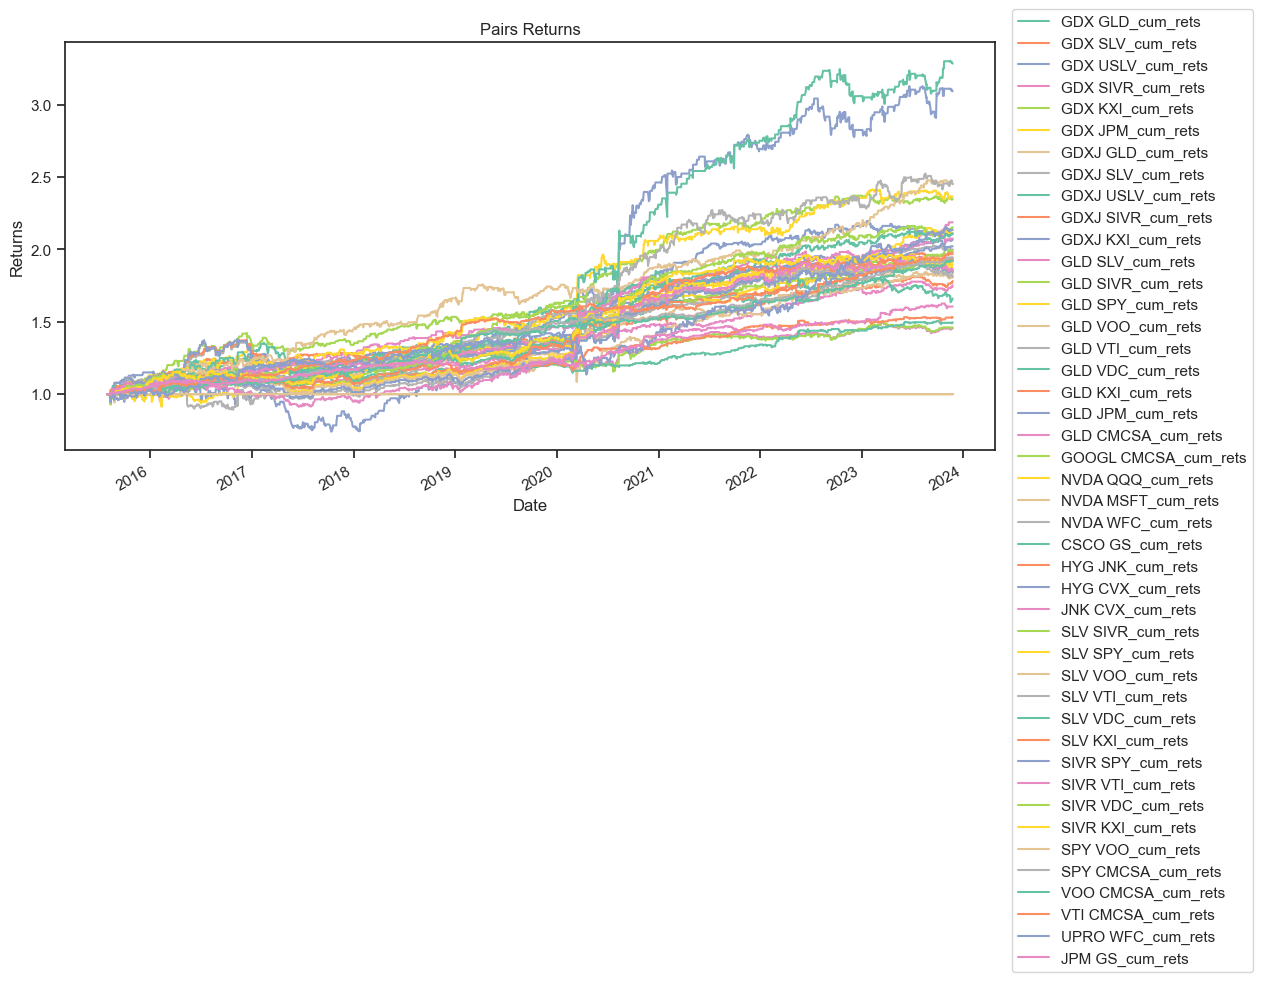

In [17]:
rets0.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
#plt.grid(b=None, which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

In [18]:
#from google.colab import drive
#drive.mount('/content/drive')

# Setting the path for the folder containing the CSV files
#folder_path = "/content/drive/MyDrive/Colab Notebooks/Algotrade/kalman-filter-pairs-trading/"

In [19]:
filename = 'pairs_rets.csv'
rets0.to_csv(filename)

In [20]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

Bin Count = 45.77116996538323


In [21]:
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

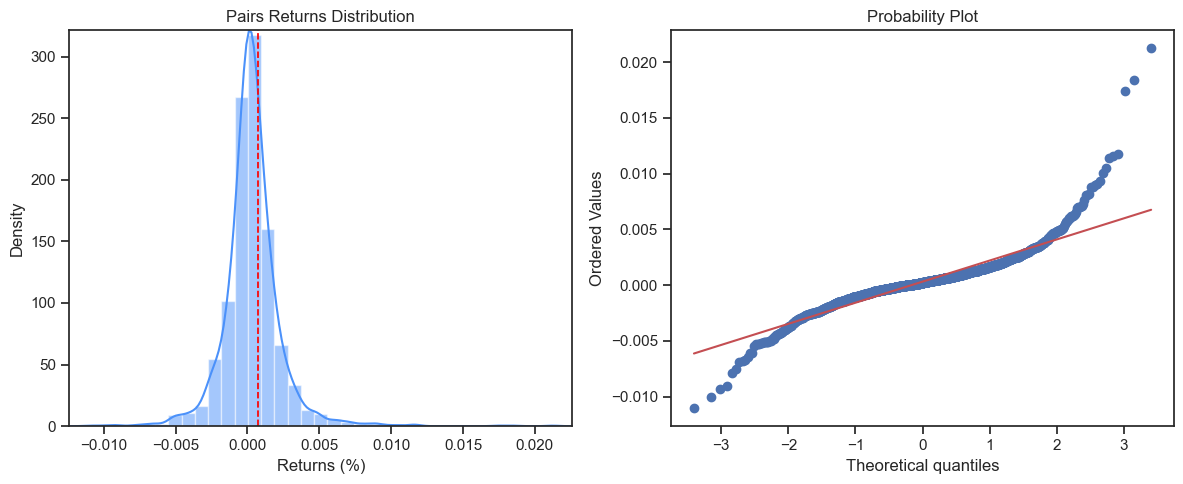

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=0.000709, color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show()

In [23]:
Pair_Rets.Pairs_Returns.describe()

count    2095.000000
mean        0.000316
std         0.002043
min        -0.011034
25%        -0.000514
50%         0.000217
75%         0.001080
max         0.021235
Name: Pairs_Returns, dtype: float64

In [24]:
perf = final_res.calc_stats()

In [25]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 44


In [26]:
# set SPY as benchmark
bench = df.loc[str(Pair_Rets.index[0]):str(Pair_Rets.index[-1])].SPY.pct_change().dropna()
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

Start date,2015-08-03
End date,2023-11-24
Total months,99
,Backtest
Annual return,8.236%
Cumulative returns,93.029%
Annual volatility,3.243%
Sharpe ratio,2.46
Calmar ratio,2.32
Stability,0.97
Max drawdown,-3.543%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.54,2016-11-30,2017-05-17,2017-11-01,241
1,1.91,2017-11-22,2018-01-09,2018-02-16,63
2,1.38,2020-07-20,2020-07-27,2020-08-04,12
3,1.36,2020-03-10,2020-03-12,2020-03-16,5
4,1.33,2021-01-25,2021-02-01,2021-02-02,7


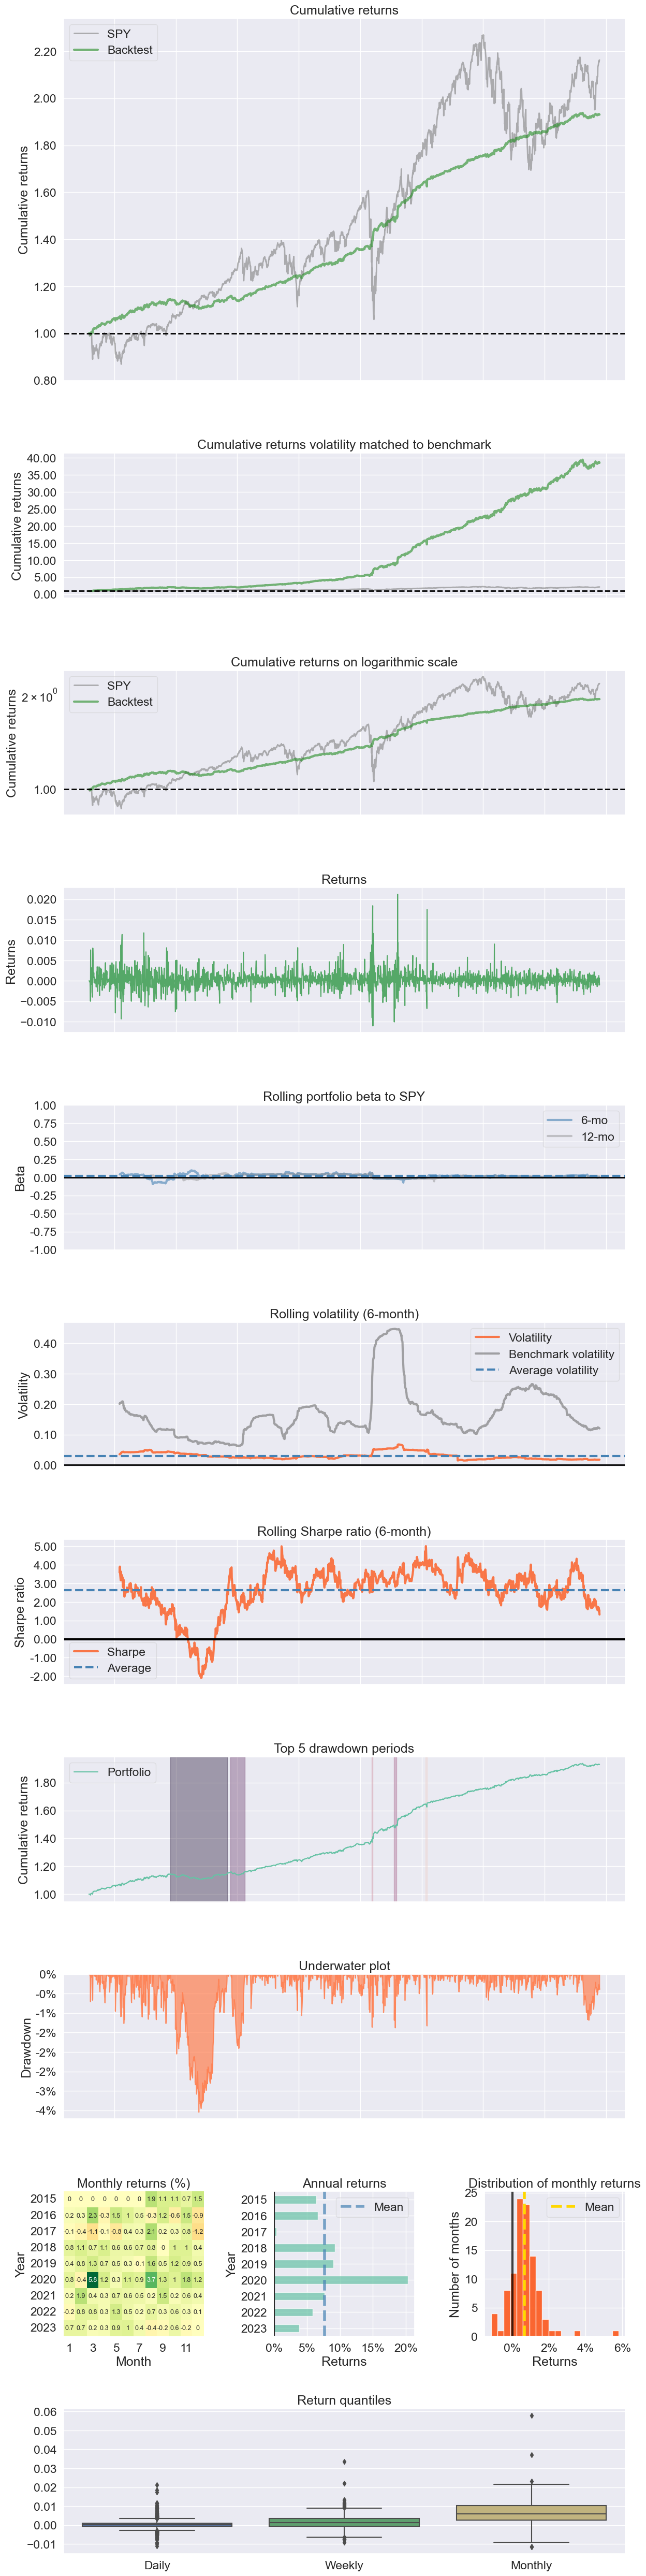

In [27]:
fig = pf.create_returns_tear_sheet(Pair_Rets.Pairs_Returns, benchmark_rets=bench)